In [1]:
import torch
import os
import random

from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import matplotlib.pyplot as plt

In [2]:
dataset_path = "D:\\Baburam\\Graph Project\\project\\train"

In [3]:
dataset = []
for class_i in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, class_i)
    for filename in os.listdir(file_path):
        filename_path = os.path.join(file_path, filename)
        dataset.append(filename_path)
    
total = len(dataset)

dataset = random.sample(dataset, len(dataset))

train_dataset = dataset[:int(total * 0.7)]
val_dataset = dataset[int(total * 0.7):]

print(f"total dataset: {len(dataset)}")
print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")

total dataset: 26604
train_dataset: 18622
val_dataset: 7982


In [4]:
train_list = list()
for train_ds in train_dataset:
    train_list.append(torch.load(train_ds))
    
val_list = list()
for val_ds in val_dataset:
    val_list.append(torch.load(val_ds))

In [5]:
train_loader = DataLoader(train_list, batch_size=128, shuffle=True)
val_loader = DataLoader(val_list, batch_size=128, shuffle=True)

In [6]:
from torch_geometric.nn import GraphConv
import torch
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(3, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        # self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 7)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=16)
print(model)

GNN(
  (conv1): GraphConv(3, 16)
  (conv2): GraphConv(16, 16)
  (lin): Linear(in_features=16, out_features=7, bias=True)
)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [14]:
train_accuracy = list()
val_accuracy = list()
epochs = 170
for epoch in range(1, (epochs+1)):
    train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.3587, Validation Acc: 0.3510
Epoch: 002, Train Acc: 0.3922, Validation Acc: 0.3865
Epoch: 003, Train Acc: 0.3886, Validation Acc: 0.3831
Epoch: 004, Train Acc: 0.3551, Validation Acc: 0.3499
Epoch: 005, Train Acc: 0.3809, Validation Acc: 0.3767
Epoch: 006, Train Acc: 0.3820, Validation Acc: 0.3748
Epoch: 007, Train Acc: 0.3839, Validation Acc: 0.3799
Epoch: 008, Train Acc: 0.3922, Validation Acc: 0.3869
Epoch: 009, Train Acc: 0.3915, Validation Acc: 0.3816
Epoch: 010, Train Acc: 0.3850, Validation Acc: 0.3766
Epoch: 011, Train Acc: 0.3876, Validation Acc: 0.3836
Epoch: 012, Train Acc: 0.3790, Validation Acc: 0.3697
Epoch: 013, Train Acc: 0.3284, Validation Acc: 0.3225
Epoch: 014, Train Acc: 0.3396, Validation Acc: 0.3343
Epoch: 015, Train Acc: 0.3849, Validation Acc: 0.3796
Epoch: 016, Train Acc: 0.3763, Validation Acc: 0.3702
Epoch: 017, Train Acc: 0.3778, Validation Acc: 0.3723
Epoch: 018, Train Acc: 0.3983, Validation Acc: 0.3921
Epoch: 019, Train Acc: 0.390

ValueError: x and y must have same first dimension, but have shapes (170,) and (0,)

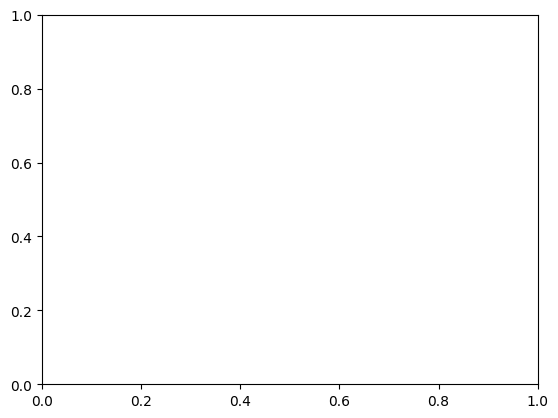

In [13]:
# Plotting
epochs = [i for i in range(1, (epochs+1))]
plt.plot(epochs, train_accuracy, label='train')
plt.plot(epochs, val_accuracy, label='test')
plt.legend()
plt.plot()